In [1]:
import time
import unittest
from test.test_meteorology import Test_heat_index

import cupy as cp
import dask
import numpy as np
import pandas as pd
import src.geocat.comp.meteorology as geo
from src.geocat.comp.comp_util import _convert_to_gpu_array, _convert_to_cpu_array
import xarray as xr
csvpath = "Heat_index_ported_test_numpy.csv"

## Plotting and Validation

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot(allData,name):
    arraysizes = np.unique(allData['ArraySize'])
    sd_numpy = np.zeros(len(arraysizes))
    sd_cupy = np.zeros(len(arraysizes))
    y_numpy = np.zeros(len(arraysizes))
    y_cupy = np.zeros(len(arraysizes))
    plt.rcParams.update({'font.size': 20})
    for i in range(0,len(arraysizes)):
        cupydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'cupy')]
        numpydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'numpy')]
        y_cupy[i] = np.mean(cupydata['Runtime(s)'])
        y_numpy[i] = np.mean(numpydata['Runtime(s)'])
        sd_cupy[i] = np.std(cupydata['Runtime(s)'])
        sd_numpy[i] = np.std(numpydata['Runtime(s)'])
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.errorbar(arraysizes, y_numpy, yerr=sd_numpy, fmt='-o',label='numpy')
    ax.errorbar(arraysizes, y_cupy, yerr=sd_cupy, fmt='-o',label='cupy')
    ax.legend();  # Add a legend.
    ax.set_xlabel('ArraySize')  # Add an x-label to the axes.
    ax.set_ylabel('Runtime(s)')  # Add a y-label to the axes.
    ax.set_title(("Test_heat_index"))
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.savefig(name,dpi=fig.dpi)

def test_validation(res_numpy,res_cupy):
    assert np.allclose(res_numpy,res_cupy, atol=0.0000001)

## Cluster

### Local CUDA Cluster

In [3]:
# import dask.distributed as dd
# #client = dd.Client()
# from dask_cuda import LocalCUDACluster
# cluster = LocalCUDACluster()
# client = dd.Client(cluster)

### CPU cluster on PBS cluster

In [4]:
# import dask.array as da
from dask_jobqueue import PBSCluster
from dask.distributed import Client

clusterCPU = PBSCluster(memory='100 GB',
                     processes=2,
                     cores=2,
                     queue='casper',
                     walltime='02:00:00',
                     resource_spec='select=1:ncpus=2:mem=100gb')
print(clusterCPU.job_script())
clusterCPU.scale(1)
client = Client(clusterCPU)
#cluster.close()


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A NTDD0005
#PBS -l select=1:ncpus=2:mem=100gb
#PBS -l walltime=02:00:00

/glade/work/hkashgar/conda-envs/geocat/bin/python -m distributed.cli.dask_worker tcp://10.12.205.44:32949 --nthreads 1 --nprocs 2 --memory-limit 46.57GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.44:32949,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### CUDA cluster on PBS cluster

In [6]:
# import dask.array as da
from dask_jobqueue import PBSCluster
from dask.distributed import Client

clusterCUDA = PBSCluster(memory='200 GB',
                     processes=1,
                     cores=1,
                     queue='casper',
                     walltime='02:00:00',
                     resource_spec='select=1:ncpus=1:ngpus=1:mem=200gb')
print(clusterCUDA.job_script())
clusterCUDA.scale(1)
client = Client(clusterCUDA)
#cluster.close()

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A NTDD0005
#PBS -l select=1:ncpus=1:ngpus=1:mem=200gb
#PBS -l walltime=02:00:00

/glade/work/hkashgar/conda-envs/geocat/bin/python -m distributed.cli.dask_worker tcp://10.12.205.44:39194 --nthreads 1 --memory-limit 186.26GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39054 instead
  warnings.warn(


In [7]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/39054/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/39054/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.44:39194,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/39054/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Initializing Arrays

In [8]:
max_power = 8
chunksize = 10**5
t_def_arrays = []
rh_def_arrays = []
for i in range(1,max_power):
    ArraySize = 10**i
    t_def_arrays.append(xr.DataArray(np.random.uniform(low=30,high=104,size=10**i)))
    rh_def_arrays.append(xr.DataArray(np.random.uniform(low=40,high=90,size=10**i)))
numpy_results = []
cupy_results = []

## Testing Numpy input and CPU

In [9]:
xp = np
for i in range(4-1):
    t_def = t_def_arrays[i].data
    rh_def = rh_def_arrays[i].data
    rh_gt_1 = geo.heat_index(t_def, rh_def, use_gpu = False)

/glade/u/home/hkashgar/GPU_data_analysis_rapids/geocat-comp/src/geocat/comp/meteorology.py:136: RuntimeWarning: invalid value encountered in sqrt
  heatindex - ((13 - relative_humidity) / 4) * np.sqrt(


In [10]:
rh_gt_1[0]

30.07253895646074

## Testing Numpy input and GPU

In [11]:
for i in range(4-1):
    t_def = t_def_arrays[i].data
    rh_def = rh_def_arrays[i].data
    rh_gt_2 = geo.heat_index(t_def, rh_def, use_gpu = True)

In [12]:
type(rh_gt_2)

cupy._core.core.ndarray

In [13]:
rh_gt_2[0]

array(30.07253896)

In [14]:
i = 0
t_def = t_def_arrays[i]
rh_def = rh_def_arrays[i]
print(type(t_def.data))
a,b = _convert_to_gpu_array([t_def, rh_def])
print(type(b.data))

<class 'numpy.ndarray'>
<class 'cupy._core.core.ndarray'>


## Testing Xarray input and CPU

In [15]:
# for i in range(max_power-1):
#     t_def = t_def_arrays[i]
#     rh_def = rh_def_arrays[i]
#     a = geo.heat_index(t_def, rh_def, use_gpu = False)

## Testing Xarray input and GPU

In [16]:
# for i in range(max_power-1):
#     t_def = t_def_arrays[i]
#     rh_def = rh_def_arrays[i]
#     b = geo.heat_index(t_def, rh_def, use_gpu = True)

In [17]:
#type(b[0].data)

## Testing Dask input with CPU

In [18]:
# for i in range(3):
#     t_def = t_def_arrays[i].chunk(10)
#     rh_def = rh_def_arrays[i].chunk(10)
#     a = geo.heat_index(t_def, rh_def, use_gpu = False).compute()

In [19]:
# t_def = t_def_arrays[0].chunk(10)
# rh_def = rh_def_arrays[0].chunk(10)
# geo.heat_index(t_def, rh_def, use_gpu = False)

In [20]:
# a[0]

## Testing Dask input with GPU

In [21]:
# for i in range(3):
#     t_def = t_def_arrays[i].chunk(10)
#     rh_def = rh_def_arrays[i].chunk(10)
#     b = geo.heat_index(t_def, rh_def, use_gpu = True).compute()

In [22]:
t_def = t_def_arrays[0].chunk(10)
rh_def = rh_def_arrays[0].chunk(10)
geo.heat_index(t_def, rh_def, use_gpu = True)

<xarray.DataArray 'asarray-62a7c799f5b8ab3807df7b26bab5a16c' (dim_0: 10)>
dask.array<where, shape=(10,), dtype=float64, chunksize=(10,), chunktype=cupy.ndarray>
Dimensions without coordinates: dim_0
Attributes:
    long_name:  heat index: NWS
    units:      F
    www:        https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml
    info:       appropriate for shady locations with no wind
    tag:        NCL: heat_index_nws; (Steadman+t)*0.5 and Rothfusz

In [23]:
type(b[0].data)

cupy._core.core.ndarray

## Unittests with CPU!

In [24]:
client = Client(clusterCPU)
test = Test_heat_index()

test.setUpClass()
test.test_float_input(use_gpu = False)
test.test_list_input(use_gpu = False)
test.test_numpy_input(use_gpu = False)
test.test_dims_error()
test.test_xarray_type_error()
test.test_dask_compute(use_gpu = False)
test.test_dask_lazy(use_gpu = False)
test.test_multi_dimensional_input(use_gpu = False)
test.test_alt_coef(use_gpu = False)
test.test_xarray_alt_coef(use_gpu = False)
test.test_alternate_xarray_tag(use_gpu = False)
test.test_rh_warning()
test.test_rh_valid()
test.test_xarray_rh_warning()
test.test_xarray_rh_valid()
test.test_xarray_input(use_gpu=False)

/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46208 instead
  warnings.warn(
2022-07-15 12:42:36,395 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/u/home/hkashgar/GPU_data_analysis_rapids/geocat-comp/dask-worker-space/worker-d5h32r0v', purging
2022-07-15 12:42:36,410 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/u/home/hkashgar/GPU_data_analysis_rapids/geocat-comp/dask-worker-space/worker-7ct592wb', purging
/glade/u/home/hkashgar/GPU_data_analysis_rapids/geocat-comp/src/geocat/comp/meteorology.py:136: RuntimeWarning: invalid value encountered in sqrt
  heatindex - ((13 - relative_humidity) / 4) * np.sqrt(
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute

## Unittests with GPU

In [25]:
client = Client(clusterCUDA)
test = Test_heat_index()

test.setUpClass()
test.test_float_input(use_gpu = True)
test.test_list_input(use_gpu = True)
test.test_numpy_input(use_gpu = True)
test.test_dims_error()
test.test_xarray_type_error()
test.test_dask_compute(use_gpu = True)
test.test_dask_lazy(use_gpu = True)
test.test_multi_dimensional_input(use_gpu = True)
test.test_alt_coef(use_gpu = True)
test.test_xarray_alt_coef(use_gpu = True)
test.test_alternate_xarray_tag(use_gpu = True)
test.test_rh_warning()
test.test_rh_valid()
test.test_xarray_rh_warning()
test.test_xarray_rh_valid()
test.test_xarray_input(use_gpu=True)

/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38252 instead
  warnings.warn(
/glade/u/home/hkashgar/GPU_data_analysis_rapids/geocat-comp/src/geocat/comp/meteorology.py:136: RuntimeWarning: invalid value encountered in sqrt
  heatindex - ((13 - relative_humidity) / 4) * np.sqrt(


## Benchmark Results for different Array Sizes (NUMPY/CUPY)

heat_index
Array size:  10
numpy 0.00017802715301513673 seconds
cupy 0.001670527458190918 seconds
Array size:  100
numpy 0.0001800060272216797 seconds
cupy 0.0017413854598999023 seconds
Array size:  1000
numpy 0.0002648591995239258 seconds
cupy 0.0020760059356689452 seconds
Array size:  10000
numpy 0.0008897066116333007 seconds
cupy 0.0025725603103637696 seconds
Array size:  100000


/glade/u/home/hkashgar/GPU_data_analysis_rapids/geocat-comp/src/geocat/comp/meteorology.py:136: RuntimeWarning: invalid value encountered in sqrt
  heatindex - ((13 - relative_humidity) / 4) * np.sqrt(


numpy 0.007891297340393066 seconds
cupy 0.005680394172668457 seconds
Array size:  1000000
numpy 0.10264334678649903 seconds
cupy 0.04121165275573731 seconds
Array size:  10000000
numpy 1.465722393989563 seconds
cupy 0.40667908191680907 seconds


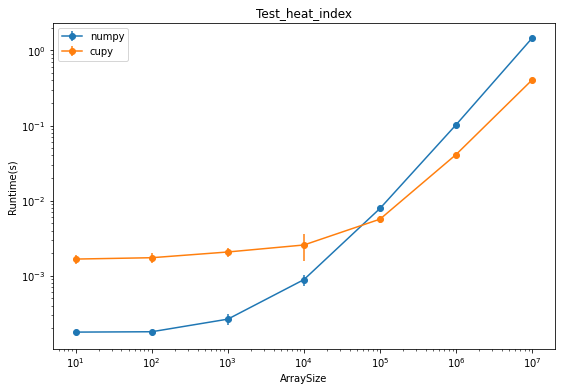

In [26]:
#Test_heat_index main body
Routine = "heat_index"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    t_def = t_def_arrays[i-1].data
    rh_def = rh_def_arrays[i-1].data
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    for xp in [np,cp]:
        #calculation will be repeated 10 time to get the less biased performance results
        repsize = 10
        repeat = np.zeros([repsize])
        for rep in range(0,repsize):
            #create different sizes of arrays
            if(xp == cp):
                res_cupy = geo.heat_index(t_def, rh_def, use_gpu = True)
                cp.cuda.runtime.deviceSynchronize()
                time1 = time.time()
                res_cupy = geo.heat_index(t_def, rh_def, use_gpu = True)
                cp.cuda.runtime.deviceSynchronize()
                time2 = time.time()
                repeat[rep] = time2-time1
            else:
                res_numpy = geo.heat_index(t_def, rh_def, use_gpu = False)
                time1 = time.time()
                res_numpy = geo.heat_index(t_def, rh_def, use_gpu = False)
                time2 = time.time()
                repeat[rep] = time2-time1
        #save times
        data = {'Routine': np.repeat(Routine, repsize),
                'Input':"NumPy input",
                'Approach': np.repeat(xp.__name__ , repsize),
                'ArraySize': np.repeat(ArraySize , repsize),
                'iteration' : np.arange(1,repsize+1),
                'Runtime(s)': repeat}

        allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
        print(xp.__name__,np.mean(repeat), "seconds")
    test_validation(res_numpy,res_cupy)
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)
plot(allData,"Test_heat_index_ported_numpy.jpg")

In [ ]:
type(res_cupy)

cupy._core.core.ndarray

## Results for different ArraySizes Xarray (with NumPy/CuPy arrays inside the Xarray)

### Test heat_index on CPU

In [38]:
client = Client(clusterCPU)
client

<Client: 'tcp://10.12.205.44:32949' processes=2 threads=2, memory=93.14 GiB>

In [39]:
csvpath = "heat_index_ported_test_xarray.csv"
#Test_heat_index main body
Routine = "heat_index"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    t_def = t_def_arrays[i-1]
    rh_def = rh_def_arrays[i-1]
    #for numpy and cupy both
    xp = np 
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
    #create different sizes of arrays
        numpy_res = geo.heat_index(t_def, rh_def, False)
        time1 = time.time()
        numpy_res = geo.heat_index(t_def, rh_def,False)
        time2 = time.time()
        repeat[rep] = time2-time1
    numpy_results.append(numpy_res)
    #save times
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with NumPy input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

heat_index
Array size:  10
numpy 0.006547284126281738 seconds
Array size:  100


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/

numpy 0.006954550743103027 seconds
Array size:  1000
numpy 0.00811910629272461 seconds
Array size:  10000


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/

numpy 0.00880758762359619 seconds
Array size:  100000


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/

numpy 0.017543649673461913 seconds
Array size:  1000000


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/

numpy 0.14453117847442626 seconds
Array size:  10000000


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/

numpy 2.083319902420044 seconds


### Test heat_index on GPU

In [40]:
client = Client(clusterCUDA)
client

<Client: 'tcp://10.12.205.44:39194' processes=1 threads=1, memory=186.26 GiB>

In [41]:
#Test_heat_index main body
Routine = "heat_index"
print(Routine)
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    t_def = t_def_arrays[i-1]
    rh_def = rh_def_arrays[i-1]
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    xp = cp
        #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.heat_index(t_def, rh_def,True).compute()
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = geo.heat_index(t_def, rh_def,True).compute()
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
    cupy_results.append(cupy_res)
    #save times
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with NumPy input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)
# plot(allData,"heat_index_xarray_np_ported.jpg")

heat_index
Array size:  10
cupy 0.006785964965820313 seconds
Array size:  100


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/

cupy 0.0071319580078125 seconds
Array size:  1000
cupy 0.008142995834350585 seconds
Array size:  10000


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/

cupy 0.008635830879211426 seconds
Array size:  100000


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/

cupy 0.017986488342285157 seconds
Array size:  1000000


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/

cupy 0.1471459150314331 seconds
Array size:  10000000


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/xarray/core/

cupy 2.114319849014282 seconds


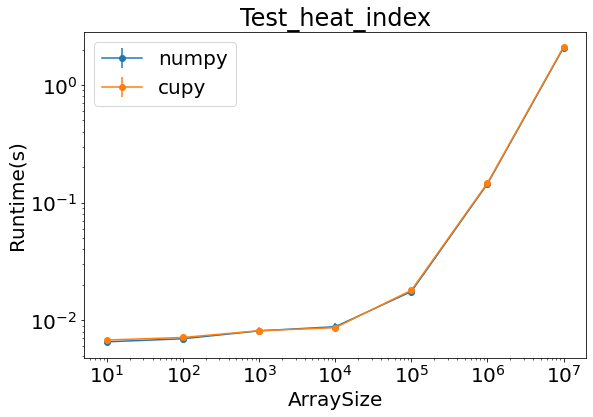

In [42]:
plot(allData,"heat_index_xarray_np_ported.jpg")

In [44]:
type(res_cupy)

cupy._core.core.ndarray

### Validation

In [34]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i].data,numpy_results[i].data)

AssertionError: 

In [ ]:
cupy_results[0]

In [ ]:
numpy_results[0]

## Benchmark Results for different ArraySizes Xarray (with Dask arrays inside the Xarray, then dask array type is either NumPy or CuPy)

### Test heat_index on CPU

In [ ]:
client = Client(clusterCPU)
client

In [ ]:
csvpath = "heat_index_ported_test_dask.csv"
#Test_heat_index main body
Routine = "heat_index"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    p_def = p_def_arrays[i-1].chunk(chunksize)
    t_def = t_def_arrays[i-1].chunk(chunksize)
    q_def = q_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = np
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        numpy_res = geo.heat_index(t_def, q_def, p_def,False).compute()
        time1 = time.time()
        numpy_res = geo.heat_index(t_def, q_def, p_def,False).compute()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    numpy_results.append(numpy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

### Test heat_index on GPU

In [ ]:
client = Client(clusterCUDA)
client

In [ ]:
#Test_heat_index main body
Routine = "heat_index"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    p_def = p_def_arrays[i-1].chunk(chunksize)
    t_def = t_def_arrays[i-1].chunk(chunksize)
    q_def = q_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = cp
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.heat_index(t_def, q_def, p_def,True).compute()
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = geo.heat_index(t_def, q_def, p_def,True).compute()
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    cupy_results.append(cupy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    new = pd.DataFrame(data)
    allData = pd.concat([allData,new], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
    #print(np.allclose(cupy_res.data,numpy_res.data,atol=0.0000001))
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

### Validation

In [ ]:
def test_validation(res_numpy,res_cupy):
    assert np.allclose(res_numpy,res_cupy, atol=0.0000001)
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i].data,numpy_results[i].data)

In [ ]:
numpy_results[13]

In [ ]:
cupy_results[13]

In [ ]:
len(cupy_results)

### Only comparing "compute()" runtime

In [ ]:
chunksize = 100

#### on CPU

In [ ]:
client = Client(clusterCPU)
client

In [ ]:
csvpath = "heat_index_ported_test_dask_compute_10.csv"
#Test_heat_index main body
Routine = "heat_index"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,7):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    p_def = p_def_arrays[i-1].chunk(chunksize)
    t_def = t_def_arrays[i-1].chunk(chunksize)
    q_def = q_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = np
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        numpy_res = geo.heat_index(t_def, q_def, p_def,False)
        numpy_res.compute()
        time1 = time.time()
        numpy_res = numpy_res.compute()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    numpy_results.append(numpy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input compute",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

#### on GPU

In [ ]:
client = Client(clusterCUDA)
client

In [ ]:
#Test_heat_index main body
Routine = "heat_index"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,7):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    p_def = p_def_arrays[i-1].chunk(chunksize)
    t_def = t_def_arrays[i-1].chunk(chunksize)
    q_def = q_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = cp
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.heat_index(t_def, q_def, p_def,True)
        cupy_res.compute()
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = cupy_res.compute()
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    cupy_results.append(cupy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input compute",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    new = pd.DataFrame(data)
    allData = pd.concat([allData,new], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
    #print(np.allclose(cupy_res.data,numpy_res.data,atol=0.0000001))
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

#### Validation

In [ ]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i].data,numpy_results[i].data)